In [ ]:
!pip install pyrsgis
!pip install rasterio
!pip install patchify
!pip install focal-loss
!pip install segmentation_models

In [ ]:
import os
import rasterio
import numpy as np
%matplotlib inline
from osgeo import gdal

# set the directory and file 
dir = '/content/drive/MyDrive/ThesisProject/Data'
image_file_name = 'bands_lst_ndbi_ndvi_ndwi_urban_r_g_b_nir_lc.tif'
park_file_name = 'park_rst.tif'

def read_file(city):  
  '''
  read the satellite image file and corresponding mask as np.array of a given city
  '''
 
  # read image file
  image_file_path = os.path.join(dir, city, image_file_name)
  image = gdal.Open(image_file_path)
  image_array = image.ReadAsArray()
  image_array = np.transpose(image_array, [1, 2, 0])  # transpose the first and third axis
  image_array[np.isnan(image_array)] = 0              # replace nan with 0
  image_array = image_array[:, :, (1, 2, 4, 9)]    # get the bands you want
  # read park file
  park_file_path = os.path.join(dir, city, park_file_name)
  park = gdal.Open(park_file_path)
  park_array = park.ReadAsArray()
  park_array = np.expand_dims(park_array, axis = 2) # expand from 2D to 3D
  park_array[np.isnan(park_array)] = 0              # replace nan with 0
  park_array[park_array > 1] = 1                    # repalce values greater than 1 with 1

  return image_array, park_array

In [ ]:
# read image and mask files of cities
image_array_SF, park_array_SF = read_file('San_Francisco')
image_array_St, park_array_St = read_file('Seattle')
image_array_Dv, park_array_Dv = read_file('Denver')
image_array_Gt, park_array_Gt = read_file('Ghent')
image_array_Ams, park_array_Ams = read_file('Amsterdam')
image_array_GM, park_array_GM = read_file('Greater_Manchester')
image_array_Dk, park_array_Dk = read_file('Dhaka')
image_array_Ph, park_array_Ph = read_file('Philadelphia')
image_array_Dbl, park_array_Dbl = read_file('Dublin')
image_array_Ld, park_array_Ld = read_file('London')
image_array_Dls, park_array_Dls = read_file('Dallas')
image_array_Vc, park_array_Vc = read_file('Vancouver')
image_array_Bf, park_array_Bf = read_file('Buffalo')

print(image_array_SF.shape, park_array_SF.shape)
print(image_array_St.shape, park_array_St.shape)
print(image_array_Dv.shape, park_array_Dv.shape)
print(image_array_Gt.shape, park_array_Gt.shape)
print(image_array_Ams.shape, park_array_Ams.shape)
print(image_array_GM.shape, park_array_GM.shape)
print(image_array_Dk.shape, park_array_Dk.shape)
print(image_array_Ph.shape, park_array_Ph.shape)
print(image_array_Dbl.shape, park_array_Dbl.shape)
print(image_array_Ld.shape, park_array_Ld.shape)
print(image_array_Dls.shape, park_array_Dls.shape)
print(image_array_Vc.shape, park_array_Vc.shape)
print(image_array_Bf.shape, park_array_Bf.shape)

(1385, 1452, 4) (1385, 1452, 1)
(2659, 1464, 4) (2659, 1464, 1)
(2532, 3576, 4) (2532, 3576, 1)
(2195, 1820, 4) (2195, 1820, 1)
(1265, 2105, 4) (1265, 2105, 1)
(3945, 4952, 4) (3945, 4952, 1)
(1891, 1053, 4) (1891, 1053, 1)
(2894, 2738, 4) (2894, 2738, 1)
(1265, 1664, 4) (1265, 1664, 1)
(4600, 5897, 4) (4600, 5897, 1)
(4454, 4063, 4) (4454, 4063, 1)
(1248, 1462, 4) (1248, 1462, 1)
(1571, 963, 4) (1571, 963, 1)


In [ ]:
def normalize_by_layer(image_array):
  '''
  Function to normalize image data to the same max(1) and min(0)
  Since different layers have different scales, normalization will be done layer by layer
  '''
  for i in range(image_array.shape[2]):
    layer_min = np.min(image_array[:, :, i])
    layer_max = np.max(image_array[:, :, i])
    image_array[:, :, i] = (image_array[:, :, i] - layer_min)/(layer_max - layer_min)
  return image_array

In [ ]:
image_array_SF = normalize_by_layer(image_array_SF)
image_array_St = normalize_by_layer(image_array_St)
image_array_Dv = normalize_by_layer(image_array_Dv)
image_array_Gt = normalize_by_layer(image_array_Gt)
image_array_Ams = normalize_by_layer(image_array_Ams)
image_array_GM = normalize_by_layer(image_array_GM)
image_array_Dk = normalize_by_layer(image_array_Dk)
image_array_Ph = normalize_by_layer(image_array_Ph)
image_array_Dbl = normalize_by_layer(image_array_Dbl)
image_array_Ld = normalize_by_layer(image_array_Ld)
image_array_Dls = normalize_by_layer(image_array_Dls)
image_array_Vc = normalize_by_layer(image_array_Vc)
image_array_Bf = normalize_by_layer(image_array_Bf)

In [ ]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# define a function to crop images and corresponding masks into proper size
def create_chips(image_file, park_file, patch_size, step):
  '''
  This function creates chips for satellite image and corresponding masks
  Input  - image_file: np.array of satellite image
         - park_file: np.array of mask
         - patch_size: size of output chips
         - step: stride when cropping
  Output - one np.array for chips of satellite image, another one for mask
  '''
  
  image_dataset = []
  park_dataset = []
  patches_img = patchify(image_file, (patch_size, patch_size, image_file.shape[2]), step=step)  
  patches_prk = patchify(park_file, (patch_size, patch_size, park_file.shape[2]), step=step)
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]   
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds. 
      
      single_patch_prk = patches_prk[i,j,:,:]   
      single_patch_prk = single_patch_prk[0]
      
      if np.count_nonzero(single_patch_img[:, :, 2] == 1) > 0.5 * single_patch_img[:, :, 2].size:
        image_dataset.append(single_patch_img[:, :, (0, 1, 3)]) 
        park_dataset.append(single_patch_prk)
  image_dataset = np.array(image_dataset)
  park_dataset = np.array(park_dataset)

  return image_dataset, park_dataset

In [ ]:
def remove_images(image_dataset, park_dataset, threshold):
  '''
  This function remove images and corresponding masks with high proportion of backgrounds
  Input  - image_dataset, park_dataset: np.array of chips of satellite images and masks
         - threshold: if proportion of backgrounds is higher than threshold, the chips will be removed
  Output - balanced array without those chips
  '''
  
  # get the id of images to remove
  id_to_remove = []
  for i in range(len(park_dataset)):
    mask = park_dataset[i, :, :, 0]
    tot_pixel = mask.size
    background_pixel = np.count_nonzero(mask == 0)
    if background_pixel > tot_pixel * threshold:
      id_to_remove.append(i)
  
  # get the balanced dataset
  image_dataset_balanced = []
  park_dataset_balanced = []
  for i in range(len(image_dataset)):
    if not(i in id_to_remove):
      image = image_dataset[i]
      park = park_dataset[i]
      image_dataset_balanced.append(image)
      park_dataset_balanced.append(park)
  image_dataset_balanced = np.array(image_dataset_balanced)
  park_dataset_balanced = np.array(park_dataset_balanced)

  return image_dataset_balanced, park_dataset_balanced

In [ ]:
# get the balanced dataset of cities
image_dataset_SF, park_dataset_SF = create_chips(image_array_SF, park_array_SF, patch_size=256, step=32)
image_dataset_SF_balanced, park_dataset_SF_balanced = remove_images(image_dataset_SF, park_dataset_SF, 0.86)
del image_dataset_SF, park_dataset_SF
print(image_dataset_SF_balanced.shape, park_dataset_SF_balanced.shape)

image_dataset_St, park_dataset_St = create_chips(image_array_St, park_array_St, patch_size=256, step=32)
image_dataset_St_balanced, park_dataset_St_balanced = remove_images(image_dataset_St, park_dataset_St, 0.86)
del image_dataset_St, park_dataset_St
print(image_dataset_St_balanced.shape, park_dataset_St_balanced.shape)

image_dataset_Dv, park_dataset_Dv = create_chips(image_array_Dv, park_array_Dv, patch_size=256, step=32)
image_dataset_Dv_balanced, park_dataset_Dv_balanced = remove_images(image_dataset_Dv, park_dataset_Dv, 0.86)
del image_dataset_Dv, park_dataset_Dv
print(image_dataset_Dv_balanced.shape, park_dataset_Dv_balanced.shape)

image_dataset_Gt, park_dataset_Gt = create_chips(image_array_Gt, park_array_Gt, patch_size=256, step=32)
image_dataset_Gt_balanced, park_dataset_Gt_balanced = remove_images(image_dataset_Gt, park_dataset_Gt, 0.86)
del image_dataset_Gt, park_dataset_Gt
print(image_dataset_Gt_balanced.shape, park_dataset_Gt_balanced.shape)

image_dataset_Ams, park_dataset_Ams = create_chips(image_array_Ams, park_array_Ams, patch_size=256, step=32)
image_dataset_Ams_balanced, park_dataset_Ams_balanced = remove_images(image_dataset_Ams, park_dataset_Ams, 0.86)
del image_dataset_Ams, park_dataset_Ams
print(image_dataset_Ams_balanced.shape, park_dataset_Ams_balanced.shape)

image_dataset_GM, park_dataset_GM = create_chips(image_array_GM, park_array_GM, patch_size=256, step=64)
image_dataset_GM_balanced, park_dataset_GM_balanced = remove_images(image_dataset_GM, park_dataset_GM, 0.86)
del image_dataset_GM, park_dataset_GM
print(image_dataset_GM_balanced.shape, park_dataset_GM_balanced.shape)

image_dataset_Dk, park_dataset_Dk = create_chips(image_array_Dk, park_array_Dk, patch_size=256, step=32)
image_dataset_Dk_balanced, park_dataset_Dk_balanced = remove_images(image_dataset_Dk, park_dataset_Dk, 0.9)
del image_dataset_Dk, park_dataset_Dk
print(image_dataset_Dk_balanced.shape, park_dataset_Dk_balanced.shape)

image_dataset_Ph, park_dataset_Ph = create_chips(image_array_Ph, park_array_Ph, patch_size=256, step=32)
image_dataset_Ph_balanced, park_dataset_Ph_balanced = remove_images(image_dataset_Ph, park_dataset_Ph, 0.86)
del image_dataset_Ph, park_dataset_Ph
print(image_dataset_Ph_balanced.shape, park_dataset_Ph_balanced.shape)

image_dataset_Dbl, park_dataset_Dbl = create_chips(image_array_Dbl, park_array_Dbl, patch_size=256, step=32)
image_dataset_Dbl_balanced, park_dataset_Dbl_balanced = remove_images(image_dataset_Dbl, park_dataset_Dbl, 0.86)
del image_dataset_Dbl, park_dataset_Dbl
print(image_dataset_Dbl_balanced.shape, park_dataset_Dbl_balanced.shape)

image_dataset_Ld, park_dataset_Ld = create_chips(image_array_Ld, park_array_Ld, patch_size=256, step=80)
image_dataset_Ld_balanced, park_dataset_Ld_balanced = remove_images(image_dataset_Ld, park_dataset_Ld, 0.86)
del image_dataset_Ld, park_dataset_Ld
print(image_dataset_Ld_balanced.shape, park_dataset_Ld_balanced.shape)

image_dataset_Dls, park_dataset_Dls = create_chips(image_array_Dls, park_array_Dls, patch_size=256, step=80)
image_dataset_Dls_balanced, park_dataset_Dls_balanced = remove_images(image_dataset_Dls, park_dataset_Dls, 0.86)
del image_dataset_Dls, park_dataset_Dls
print(image_dataset_Dls_balanced.shape, park_dataset_Dls_balanced.shape)

image_dataset_Vc, park_dataset_Vc = create_chips(image_array_Vc, park_array_Vc, patch_size=256, step=32)
image_dataset_Vc_balanced, park_dataset_Vc_balanced = remove_images(image_dataset_Vc, park_dataset_Vc, 0.86)
del image_dataset_Vc, park_dataset_Vc
print(image_dataset_Vc_balanced.shape, park_dataset_Vc_balanced.shape)

image_dataset_Bf, park_dataset_Bf = create_chips(image_array_Bf, park_array_Bf, patch_size=256, step=32)
image_dataset_Bf_balanced, park_dataset_Bf_balanced = remove_images(image_dataset_Bf, park_dataset_Bf, 0.86)
del image_dataset_Bf, park_dataset_Bf
print(image_dataset_Bf_balanced.shape, park_dataset_Bf_balanced.shape)

(388, 256, 256, 3) (388, 256, 256, 1)
(323, 256, 256, 3) (323, 256, 256, 1)
(486, 256, 256, 3) (486, 256, 256, 1)
(132, 256, 256, 3) (132, 256, 256, 1)
(219, 256, 256, 3) (219, 256, 256, 1)
(605, 256, 256, 3) (605, 256, 256, 1)
(26, 256, 256, 3) (26, 256, 256, 1)
(1048, 256, 256, 3) (1048, 256, 256, 1)
(293, 256, 256, 3) (293, 256, 256, 1)
(316, 256, 256, 3) (316, 256, 256, 1)
(224, 256, 256, 3) (224, 256, 256, 1)
(87, 256, 256, 3) (87, 256, 256, 1)
(152, 256, 256, 3) (152, 256, 256, 1)


In [ ]:
# pool cities together
image_dataset = np.concatenate([image_dataset_St_balanced, image_dataset_Dv_balanced, 
                                image_dataset_Gt_balanced, image_dataset_Ams_balanced,
                                image_dataset_GM_balanced, image_dataset_SF_balanced,
                                image_dataset_Dk_balanced, image_dataset_Ph_balanced,
                                image_dataset_Dbl_balanced, image_dataset_Ld_balanced,
                                image_dataset_Dls_balanced, image_dataset_Vc_balanced,
                                image_dataset_Bf_balanced], axis = 0)
print(image_dataset.shape)
del image_dataset_St_balanced, image_dataset_Dv_balanced
del image_dataset_Gt_balanced, image_dataset_Ams_balanced
del image_dataset_GM_balanced, image_dataset_SF_balanced, image_dataset_Bf_balanced
del image_dataset_Dk_balanced, image_dataset_Ph_balanced, image_dataset_Vc_balanced
del image_dataset_Dbl_balanced, image_dataset_Ld_balanced, image_dataset_Dls_balanced

park_dataset = np.concatenate([park_dataset_St_balanced, park_dataset_Dv_balanced, 
                               park_dataset_Gt_balanced, park_dataset_Ams_balanced,
                               park_dataset_GM_balanced, park_dataset_SF_balanced,
                               park_dataset_Dk_balanced, park_dataset_Ph_balanced,
                               park_dataset_Dbl_balanced, park_dataset_Ld_balanced,
                               park_dataset_Dls_balanced, park_dataset_Vc_balanced,
                               park_dataset_Bf_balanced], axis = 0)
print(park_dataset.shape)
del park_dataset_St_balanced, park_dataset_Dv_balanced
del park_dataset_Gt_balanced, park_dataset_Ams_balanced
del park_dataset_GM_balanced, park_dataset_SF_balanced
del park_dataset_Dk_balanced, park_dataset_Ph_balanced, park_dataset_Dbl_balanced, park_dataset_Ld_balanced
del park_dataset_Dls_balanced, park_dataset_Vc_balanced, park_dataset_Bf_balanced

(4299, 256, 256, 3)
(4299, 256, 256, 1)


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", park_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(park_dataset))
print("Number of cell with value 1: ", np.count_nonzero(park_dataset == 1))
print("Number of cell with value 0: ", np.count_nonzero(park_dataset == 0))

Image data shape is:  (4299, 256, 256, 3)
Mask data shape is:  (4299, 256, 256, 1)
Max pixel value in image is:  1.0
Min pixel value in image is:  0.0
Labels in the mask are :  [0. 1.]
Number of cell with value 1:  71868840
Number of cell with value 0:  209870424


In [ ]:
# train-validation-test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, park_dataset, 
                                                    test_size = 0.15, random_state = 42)

del image_dataset, park_dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3654, 256, 256, 3) (645, 256, 256, 3)
(3654, 256, 256, 1) (645, 256, 256, 1)


In [ ]:
# set parameters of data augmentation
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=45, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2,  
                         zoom_range=0.2,
                         horizontal_flip=True, 
                         vertical_flip=True, 
                         fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=45, 
                          width_shift_range=0.2, 
                          height_shift_range=0.2, 
                          zoom_range=0.2, 
                          horizontal_flip=True, 
                          vertical_flip=True, 
                          fill_mode='reflect',
                          preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) 

# set the batch size of image generator
batch_size= 16

# image generator (X_train and X_test)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) 

# mask generator (y_train and y_test)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)

# put image generator and mask generator together
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_generator = my_image_mask_generator(image_generator, mask_generator)
validation_generator = my_image_mask_generator(valid_img_generator, valid_mask_generator)

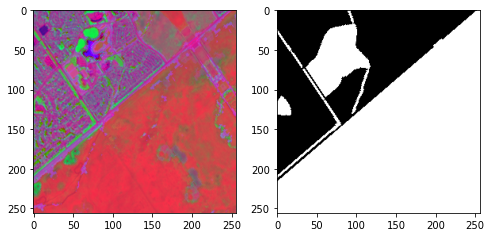

In [ ]:
# sanity check
import matplotlib.pyplot as plt

x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(8, 4))
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(normalize_by_layer(image)[:, :, ])
    
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap = 'gray')
    plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
  '''
  Each conV block consists of two convolutional layer. 
  Each convolutional layer consists of one convolutional operation (with size 3 * 3), 
  one normalization operation, one dropout layer, and one activation operation ("ReLU").
  '''
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)    
  x = Dropout(0.2)(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)  
  x = Dropout(0.2)(x)
  x = Activation("relu")(x)

  return x

# Encoder block
def encoder_block(input, num_filters):
  '''
  Encoder block consists of a conv_block and one maxpooling
  x: output of conv_block
  p: output after maxplooling
  '''
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p   

# Decoder block
def decoder_block(input, skip_features, num_filters):
  '''
  Decoder block consists of an upsampling operation, a concatenate operation, and one convolutional block
  Inputs: the output of previous layer, skip feature, and number of filters
  Skip features are the output from encoder for concatenation
  Skip feature will be concatenated with output of unsampling operation
  '''
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

# Build Unet using the blocks
def park_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024) #Bridge

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  # the output will be a one-channel image since it's a binary segmentation
  model = Model(inputs, outputs, name="U-Net")
  return model

In [ ]:
batch_size = 16
steps_per_epoch = len(X_train)//batch_size  # for generator
validation_steps = len(X_test)//batch_size  # for generator
print(steps_per_epoch, validation_steps)

228 40


In [ ]:
# compile model
# use focal loss as the loss function
import tensorflow as tf
from focal_loss import BinaryFocalLoss

input_shape = (256, 256, 3)
model = park_unet(input_shape)
model.compile(optimizer = Adam(learning_rate = 1e-4), 
              loss = BinaryFocalLoss(gamma = 2), 
              metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Epoch 1/50
228/228 [==============================] - 135s 515ms/step - loss: 0.1441 - accuracy: 0.7494 - precision: 0.5412 - recall: 0.5909 - val_loss: 0.1574 - val_accuracy: 0.6418 - val_precision: 0.4066 - val_recall: 0.8032
Epoch 2/50
228/228 [==============================] - 115s 506ms/step - loss: 0.1064 - accuracy: 0.8095 - precision: 0.6505 - recall: 0.6611 - val_loss: 0.1505 - val_accuracy: 0.6986 - val_precision: 0.4584 - val_recall: 0.7946
Epoch 3/50
228/228 [==============================] - 115s 507ms/step - loss: 0.0985 - accuracy: 0.8241 - precision: 0.6740 - recall: 0.6834 - val_loss: 0.1138 - val_accuracy: 0.7937 - val_precision: 0.6172 - val_recall: 0.5738
Epoch 4/50
228/228 [==============================] - 115s 506ms/step - loss: 0.0955 - accuracy: 0.8297 - precision: 0.6875 - recall: 0.6854 - val_loss: 0.1119 - val_accuracy: 0.7949 - val_precision: 0.7151 - val_recall: 0.3888
Epoch 5/50
228/228 [==============================] - 115s 505ms/step - loss: 0.0941 - a

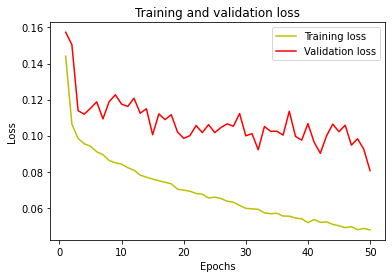

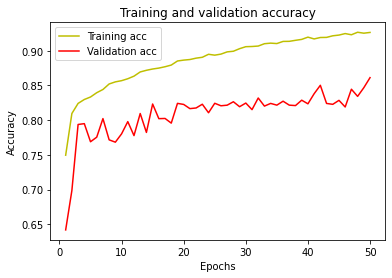

In [ ]:
from keras.callbacks import EarlyStopping

# set epochs and early stopping
epochs = 50

history_2 = model.fit(train_generator, validation_data = validation_generator,
                      batch_size = batch_size, steps_per_epoch = steps_per_epoch,
                      validation_steps = validation_steps, epochs = epochs)
# save model
model.save('/content/drive/MyDrive/ThesisProject/unet-ndvindbilc.h5')

#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Metrics
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

# IoU
from tensorflow.keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes = 2)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU is ", IOU_keras.result().numpy())

# loss, accuracy, precision, recall
loss, acc, precision, recall = model.evaluate(X_test, y_test, verbose = 0)
print("Loss is ", loss)
print("Accuracy is ", acc)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", 2 * precision * recall / (precision + recall))

Mean IoU is  0.70443624
Loss is  0.06502655148506165
Accuracy is  0.8914424180984497
Precision is  0.811855137348175
Recall is  0.7290050387382507
F1 score is  0.7682027156488181


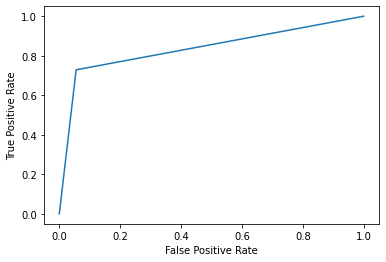

AUC is  0.836830190101669


In [ ]:
from sklearn.metrics import roc_curve
y_pred_raveled = y_pred.ravel()
y_pred_thresholded_raveled = y_pred_raveled > 0.5
y_test_raveled = y_test.ravel()

y_pred_thresholded_raveled = y_pred_thresholded_raveled.astype(int)
y_test_raveled = y_test_raveled.astype(int)
FPR, TPR, thresholds = roc_curve(y_test_raveled, y_pred_thresholded_raveled)

# create ROC curve
plt.plot(FPR,TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import auc
auc = auc(FPR, TPR)
print("AUC is ", auc)